# CDI Process Modeling (RC Circuit Approach)
**Project:** Modeling Capacitive Deionization using an equivalent RC circuit.
**Method:** Fitting experimental conductivity data to a dynamic ODE model. **Author:** Mianjian, Chemical Engineering

##  Model Description
The CDI cell is modeled as a capacitor ($C$) in series with a resistor ($R$).
* **Mass Balance:** $\frac{dC}{dt} = - \frac{I \times \Lambda}{F \times V_{tank}}$
* **Charge Balance:** $\frac{dQ}{dt} = I = \frac{V_{app} - V_{cap}}{R_{res}}$

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import curve_fit

%matplotlib inline

# ==========================================
# 1. Plotting Configuration (Publication Quality)
# ==========================================
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'font.size': 12,
    'axes.linewidth': 1.5,
    'xtick.major.width': 1.5,
    'ytick.major.width': 1.5,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'mathtext.fontset': 'cm'
})
print("Libraries loaded and plotting style configured.")

Libraries loaded and plotting style configured.


In [10]:
# ==========================================
# 2. Physical Constants & Setup
# ==========================================
CONSTANTS = {
    'V_applied': 1.2,       # Volts
    'C_initial_mg': 200.0,  # mg/L
    'Vol_tank_L': 0.050,    # Liters
    'Mass_electrode': 0.08, # grams (total)
    'C_specific': 257.0,    # F/g
    'M_NaCl': 58.44,        # g/mol
    'F': 96485.0            # C/mol
}

# Calculated parameters
C_initial_M = (CONSTANTS['C_initial_mg'] / 1000.0) / CONSTANTS['M_NaCl']
C_cell_total = (CONSTANTS['C_specific'] * CONSTANTS['Mass_electrode']) / 2

# ==========================================
# 3. Experimental Data (Input)
# ==========================================
# Time in minutes
exp_time_min = np.array([
    0, 1, 3, 4, 5,
    6, 7, 9, 10, 11,
    14, 16, 19, 21, 25, 30
])

# Conductivity in uS/cm
exp_cond_uS = np.array([
    380, 339, 305, 281, 260,
    242, 232, 221, 217, 211,
    206, 204, 202, 200, 198, 194
])

# Calibration: Conductivity -> Concentration
k_factor = CONSTANTS['C_initial_mg'] / exp_cond_uS[0]
exp_conc_mg = exp_cond_uS * k_factor
exp_time_sec = exp_time_min * 60

print(f" Data loaded. Initial Concentration: {exp_conc_mg[0]:.2f} mg/L")

 Data loaded. Initial Concentration: 200.00 mg/L


In [11]:
# ==========================================
# 4. Dynamic Model Definition (RC Circuit)
# ==========================================
def cdi_dynamic_model(y, t, R_res, charge_efficiency):
    """
    y[0]: Charge (Q) in Coulombs
    y[1]: Concentration (C) in Molar
    """
    Q = y[0]

    # 1. Voltage across Capacitor (V = Q/C)
    V_cap = Q / C_cell_total

    # 2. Effective Driving Voltage
    V_eff = CONSTANTS['V_applied'] - V_cap
    if V_eff < 0: V_eff = 0

    # 3. Current (I = V/R)
    I = V_eff / R_res

    # 4. ODEs
    dQ_dt = I
    dC_dt = - (I * charge_efficiency) / (CONSTANTS['F'] * CONSTANTS['Vol_tank_L'])

    return [dQ_dt, dC_dt]

def model_wrapper(t_points, R_fit, eff_fit):
    """Wrapper function for curve_fit"""
    y0 = [0.0, C_initial_M] # Initial Q=0, C=C0

    t_continuous = np.linspace(0, max(t_points), 500)
    sol = odeint(cdi_dynamic_model, y0, t_continuous, args=(R_fit, eff_fit))

    # Interpolate to match experimental time points
    c_simulated_M = np.interp(t_points, t_continuous, sol[:, 1])

    return c_simulated_M * CONSTANTS['M_NaCl'] * 1000.0

--- Running Optimization ---
 Optimization Successful!
   Effective Resistance (R): 27.68 Ω
   Charge Efficiency:        64.9 %
   Model Accuracy (R2):      0.9934


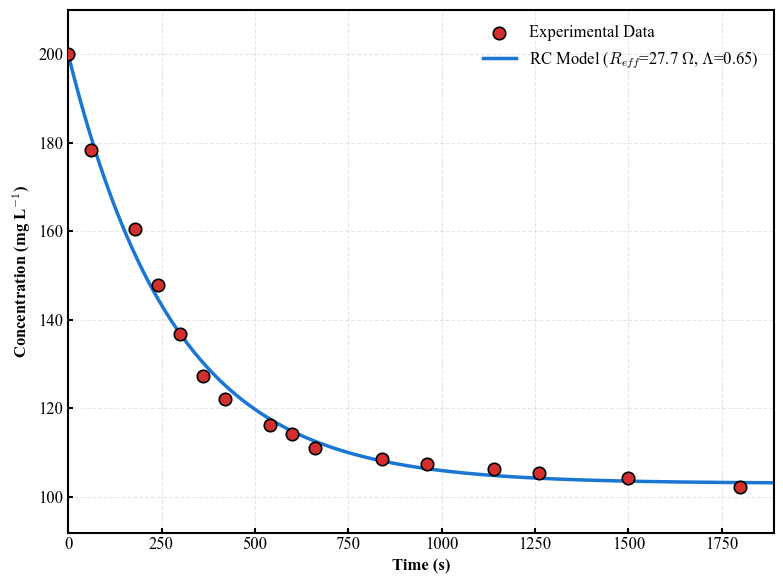

In [12]:
print("--- Running Optimization ---")

# Initial guesses: R=25 Ohm, Efficiency=66%
initial_guess = [25.0, 0.66]
bounds = ([1.0, 0.1], [1000.0, 1.0])

try:
    # 1. Fit the model
    popt, pcov = curve_fit(model_wrapper, exp_time_sec, exp_conc_mg, p0=initial_guess, bounds=bounds)
    best_R, best_eff = popt

    # 2. Calculate R2
    residuals = exp_conc_mg - model_wrapper(exp_time_sec, *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((exp_conc_mg - np.mean(exp_conc_mg))**2)
    r_squared = 1 - (ss_res / ss_tot)

    print(f" Optimization Successful!")
    print(f"   Effective Resistance (R): {best_R:.2f} \u03A9")
    print(f"   Charge Efficiency:        {best_eff*100:.1f} %")
    print(f"   Model Accuracy (R2):      {r_squared:.4f}")

    # 3. Plotting
    t_smooth = np.linspace(0, max(exp_time_sec)*1.1, 1000)
    c_smooth_mg = model_wrapper(t_smooth, best_R, best_eff)

    plt.figure(figsize=(8, 6))

    # Experimental Data
    plt.scatter(exp_time_sec, exp_conc_mg, color='#D32F2F', marker='o', s=80,
                edgecolors='black', linewidth=1.2, zorder=5, label='Experimental Data')

    # Model Fit
    plt.plot(t_smooth, c_smooth_mg, color='#1976D2', linestyle='-', linewidth=2.5,
             label=f'RC Model ($R_{{eff}}$={best_R:.1f} $\\Omega$, $\\Lambda$={best_eff:.2f})')

    plt.xlabel('Time (s)', fontweight='bold')
    plt.ylabel('Concentration (mg L$^{-1}$)', fontweight='bold')

    plt.xlim(0, max(exp_time_sec)*1.05)
    plt.ylim(min(exp_conc_mg)*0.9, max(exp_conc_mg)*1.05)

    plt.legend(frameon=False)
    plt.grid(True, linestyle='--', alpha=0.3)

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error during optimization: {e}")